In [1]:
#Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

import os
from os import listdir
from os.path import isfile, join
import time
import cv2


# 1. Data loading and preparation

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/")
!ls
%cd MyDrive

In [3]:
fpath_C = 'FV-Cells/Policristal/Full_Defected'
fpath_G = 'FV-Cells/Policristal/Full_Undefected'

filesG = [os.path.join(root, name)
            for root, dirs, files in os.walk(fpath_G)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]
filesC = [os.path.join(root, name)
            for root, dirs, files in os.walk(fpath_C)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]
ROIs = [os.path.join(root, name)
            for root, dirs, files in os.walk(fpath_C)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' in name)]
print(len(filesG), len(filesC), len(ROIs))

150 145 145


Load images from paths

In [4]:
imgG = [] #Undefected cells 
imgC = [] #Cracked (defected) cells
ROI = []  #ROIs of defected cells

for pth in filesG:
  img = cv2.imread(pth,0)/255.
  imgG.append(img)
for pth in filesC:
  img = cv2.imread(pth,0)/255.
  imgC.append(img)
for pth in ROIs:
  img = cv2.imread(pth,0)/255.
  ROI.append(img)

#Convert images to numpy arrays:
imgG = np.array(imgG)
imgC = np.array(imgC)
ROI = np.array(ROI)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when c

Some visualization

In [ ]:
plt.imshow(ROI[8], interpolation='nearest')
plt.show()
fname = filesG[100]
print(fname, len(filesG))
img = cv2.imread(fname,0)/255.

plt.figure(figsize=(15, 15))
#plt.subplot(221)
plt.imshow(img)
plt.show()
print(img.shape, img.max())

w = 512
h = 512
dim = (w, h)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

plt.figure(figsize=(15, 15))
#plt.subplot(221)
plt.imshow(resized)
plt.show()
print(resized.shape, resized.max())

Output hidden; open in https://colab.research.google.com to view.

# 1.1 Segmentation

In [ ]:
#Create directories for training data generation

pth = "DL_Project/FV-Cells/Policristal/segmentation"
os.mkdir(pth)

target_path = pth + "/train"
try:
    os.stat(target_path)
except:
    os.mkdir(target_path)
try:
    os.stat(target_path+'/bad')
except:
    os.mkdir(target_path+'/bad')
try:
    os.stat(target_path+'/good')
except:
    os.mkdir(target_path+'/good')
    
from random import randint
import shutil

valid_path = pth + "/validation"
try:
    os.stat(valid_path)
except:
    os.mkdir(valid_path)
try:
    os.stat(valid_path+'/bad')
except:
    os.mkdir(valid_path+'/bad')
try:
    os.stat(valid_path+'/good')
except:
    os.mkdir(valid_path+'/good')


FileExistsError: ignored

Segmentation function

In [ ]:
#--------------------------------------
### IMAGE PROCESSING && SAVING
def img_procc(fname, tgt_folder,type='bad'):
    new_w = 64 #256 #128 #64 # 150
    new_h = 64 #256 #128 #64 # 150
    overlap = 0.5
    tki,tkj = 5, 5 # take 1 out of 4 images
    cnti,cntj = 5, 5
    
    img = cv2.imread(fname,0)
    #img = cv2.GaussianBlur(img,(5,5),0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    #img = img*1./255
    
    img_w = img.shape[0]
    img_h = img.shape[1]
    
    img_ROI = []
    
    #DEFINE SAVE PATH
    ROI=find_ROI_img(fname)
    #print(ROI[0])
    if ROI!=None:
        img_ROI = cv2.imread(ROI[0],0) 
        img_ROI = 1-(img_ROI/255)
    
    w_len = 0
    for i,vali in enumerate(range(0,img_w,int(new_w - overlap*new_w))):
        cnti=cnti+1
        if cnti>tki:
            cnti = 0
            h_len = 0 
            if w_len != 1: #NO estamos en la esquina de la figura
                for j,valj in enumerate(range(0,img_h,int(new_h - overlap*new_h))):
                    cntj=cntj+1
                    if cntj>tkj:
                        cntj = 0
                        if h_len != 1: # NO estamos en la esquina de la figura
                            #take img
                            w_rng = [vali, vali+new_w]
                            h_rng = [valj, valj+new_h]
                            if (vali+new_w > img_w):
                                w_len=1 #estamos en la esquina de la figura
                                w_rng = [img_w-new_w, img_w]
                            if (valj+new_h > img_h):
                                h_len=1    
                                h_rng = [img_h-new_h, img_h]

                            new_img = img[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]

                            otro = 0 #para generar otras copias en errores

                            if ROI==None:
                                #overlap = 0.3
                                dnm,fnm = os.path.split(fname)
                                nw_fname = target_path + '/good/G_' + os.path.splitext(fnm)[0] + '_' + str(i) + '_' + str(j) + os.path.splitext(fnm)[1]
                            else:
                                dnm,fnm = os.path.split(fname)
                                nw_fname = target_path + '/good/B_' + os.path.splitext(fnm)[0] + '_' + str(i) + '_' + str(j) + os.path.splitext(fnm)[1]

                                img_ROI_tmp = img_ROI[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]
                                if img_ROI_tmp.sum()>100:
                                    otro = 1
                                    cnti = tki+2 #para que coja los errores más veces que los que no.
                                    cntj = tkj+2 
                                    #overlap = 0.6
                                    nw_fname = target_path + '/' + type + '/B_' + os.path.splitext(ROI[1])[0] + '_' + str(i) + '_' + str(j) + os.path.splitext(ROI[1])[1]

                            cv2.imwrite(nw_fname, new_img) 
                            # 90 degree rotated
                            nw_fname_90 = nw_fname[:-4]+'_90'+ nw_fname[-4:]
                            rows,cols = new_img.shape
                            M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
                            dst1 = cv2.warpAffine(new_img,M,(cols,rows))
                            cv2.imwrite(nw_fname_90, dst1)

                            if otro:
                                dst2 = cv2.warpAffine(dst1,M,(cols,rows))
                                nw_fname_180 = nw_fname[:-4]+'_180'+ nw_fname[-4:]
                                cv2.imwrite(nw_fname_180, dst2)
                                dst3 = cv2.warpAffine(dst2,M,(cols,rows))
                                nw_fname_270 = nw_fname[:-4]+'_270'+ nw_fname[-4:]
                                cv2.imwrite(nw_fname_270, dst3)


def find_ROI_img(fname):
    dnm,fnm = os.path.split(fname)
    ROI_fnm = os.path.splitext(fnm)[0]+'_ROI.bmp'  
    ROI_pth = os.path.join(dnm,ROI_fnm)
    if os.path.isfile(ROI_pth):
        return ROI_pth,fnm


Execution of segmentation

In [ ]:
bmpfilesC = filesC
bmpfilesG = filesG
bmpfiles = filesC + filesG
pth = "DL_Project/FV-Cells/Policristal/segmentation"
target_path = pth + "/train"

for i,fname in enumerate(bmpfiles):
    print('PROCESSING:: ' + str(i) + ' :: ' + fname)
    #fname = bmpfiles[-10]
    try:
        img_procc(fname, target_path)
    except:
        #print(" ")
        print("Exception occurred with : " + fname)
    time.sleep(0.01)

PROCESSING:: 0 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1007.bmp
PROCESSING:: 1 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1003.bmp
PROCESSING:: 2 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1004.bmp
PROCESSING:: 3 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1002.bmp
PROCESSING:: 4 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1009.bmp
PROCESSING:: 5 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1011.bmp
PROCESSING:: 6 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1008.bmp
PROCESSING:: 7 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1010.bmp
PROCESSING:: 8 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1012.bmp
PROCESSING:: 9 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1015.bmp
PROCESSING:: 10 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1013.bmp
PROCESSING:: 11 :: drive/My Drive/DL_Project/FV-Cells/Policristal/Txarrak/1014.bmp
PROCESSING:: 1

#2. Autoencoder model

Autoencoder declaration

In [5]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

    # define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")
    

    # start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)
  


#2.1 Entire images classification

In [13]:
# Define train
path = 'DL_Project/FV-Cells/Policristal/Onak'
filesX = [os.path.join(root, name)
            for root, dirs, files in os.walk(path)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]

trainX = []
dim = (512, 512)
for pth in filesX:
  img = cv2.imread(pth,0)/255.
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  trainX.append(img)
trainX = np.array(trainX)
# and test data:
path = 'DL_Project/FV-Cells/Policristal/Txarrak'
filesY = [os.path.join(root, name)
            for root, dirs, files in os.walk(path)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]

testX = []

for pth in filesY:
  img = cv2.imread(pth,0)/255.
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  testX.append(img)

testX = np.array(testX)

In [14]:
print(testX.shape[0])

145


In [15]:
# initialize the number of epochs to train for and batch size
EPOCHS = 10
BS = 16
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(512, 512, 1)
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt, run_eagerly = True)
# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size = BS)

[INFO] building autoencoder...
Epoch 1/10
10/10 [==============================] - 138s 14s/step - loss: 0.0654 - val_loss: 0.0861
Epoch 2/10
10/10 [==============================] - 119s 12s/step - loss: 0.0470 - val_loss: 0.0495
Epoch 3/10
10/10 [==============================] - 119s 12s/step - loss: 0.0324 - val_loss: 0.0365
Epoch 4/10
10/10 [==============================] - 119s 12s/step - loss: 0.0302 - val_loss: 0.0364
Epoch 5/10
10/10 [==============================] - 133s 14s/step - loss: 0.0236 - val_loss: 0.0292
Epoch 6/10
10/10 [==============================] - 135s 14s/step - loss: 0.0176 - val_loss: 0.0266
Epoch 7/10
10/10 [==============================] - 134s 14s/step - loss: 0.0150 - val_loss: 0.0248
Epoch 8/10
10/10 [==============================] - 134s 14s/step - loss: 0.0131 - val_loss: 0.0194
Epoch 9/10
10/10 [==============================] - 134s 14s/step - loss: 0.0106 - val_loss: 0.0179
Epoch 10/10
10/10 [==============================] - 124s 13s/step - 

In [25]:
decoded = autoencoder.predict(testX)
goods = autoencoder.predict(trainX)



In [26]:
errorsg = []
for (image, recon) in zip(trainX, goods):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	# and also comute the index of current image and if it's anomaly write it to Indexes.txt
	# and the number of detected anomalies is stored in num_anom variable
	mse = np.mean((image - recon) ** 2)
	errorsg.append(mse) 
mean = sum(errorsg)/len(errorsg)
sigma = np.std(errorsg)
thrashold = mean + 2*sigma
print(thrashold)

0.04929428153830025


In [27]:
print(sigma)

0.01870814771093083


/content/drive/MyDrive/DL_Project
12
89


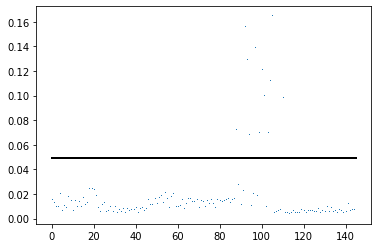

In [28]:
from re import I
errors = []
anom = []
import os
os.chdir("/content/drive")
%cd MyDrive/DL_Project
i = 1
num_anom = 0

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(testX, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	# and the number of detected anomalies is stored in num_anom variable
	mse = np.mean((image - recon) ** 2)
	errors.append(mse) 

with open('Indexes.txt', 'w') as writefile:
	writefile.write("Indexes of detected anomalies:\n")

for e in errors:
  if e > thrashold:
    with open('Indexes.txt', 'a') as writefile:
      writefile.write(str(i)+"\n")
    num_anom += 1
    anom.append(i)
  i += 1
plt.plot(errors,',')
plt.plot([0, testX.shape[0]], [thrashold, thrashold], 'k-', lw=2)
print(num_anom)
print(anom[0])

#2.2 Use segmentation before training autoencoder

In [ ]:
# Define train
path = 'DL_Project/FV-Cells/Policristal/segmentation/train/good'
filesX = [os.path.join(root, name)
            for root, dirs, files in os.walk(path)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('B' not in name)]

trainX = []

for pth in filesX:
  img = cv2.imread(pth,0)/255.
  trainX.append(img)
trainX = np.array(trainX)
# and test data:
path = 'DL_Project/FV-Cells/Policristal/segmentation/validation/good'
filesY = [os.path.join(root, name)
            for root, dirs, files in os.walk(path)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]

testX = []

for pth in filesY:
  img = cv2.imread(pth,0)/255.
  testX.append(img)

testX = np.array(testX)

In [ ]:
# initialize the number of epochs and batch size
EPOCHS = 10
BS = 64
# construct the convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(64, 64, 1)
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

[INFO] building autoencoder...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
140/140 [==============================] - 93s 659ms/step - loss: 0.0110 - val_loss: 0.0208
Epoch 2/10
140/140 [==============================] - 92s 659ms/step - loss: 0.0034 - val_loss: 0.0172
Epoch 3/10
140/140 [==============================] - 92s 660ms/step - loss: 0.0028 - val_loss: 0.0108
Epoch 4/10
140/140 [==============================] - 92s 658ms/step - loss: 0.0024 - val_loss: 0.0064
Epoch 5/10
140/140 [==============================] - 92s 658ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 6/10
140/140 [==============================] - 92s 658ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 7/10
140/140 [==============================] - 92s 659ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 8/10
140/140 [==============================] - 92s 660ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 9/10
140/140 [==============================] - 92s 659ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 10/10
140/140 [==============================] - 92s 659ms/step - l

In [ ]:
#Testing with good and bad images:
path = 'DL_Project/FV-Cells/Policristal/segmentation/validation'
filesT = [os.path.join(root, name)
            for root, dirs, files in os.walk(path)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]

testing = []

for pth in filesT:
  img = cv2.imread(pth,0)/255.
  testing.append(img)

testing = np.array(testing)
print(len(filesT))

4955


In [ ]:
bad_path = 'DL_Project/FV-Cells/Policristal/segmentation/validation/bad'
filesbad = filesT = [os.path.join(root, name)
            for root, dirs, files in os.walk(bad_path)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]
print(len(filesbad))

1652


Make predictions to allow anomaly detection

In [ ]:
decoded = autoencoder.predict(testing)
goods = autoencoder.predict(testX)

Make a threshold for anomaly detection, based on test images

In [ ]:
errorsg = []
for (image, recon) in zip(testX, goods):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	# and also comute the index of current image and if it's anomaly write it to Indexes.txt
	# and the number of detected anomalies is stored in num_anom variable
	mse = np.mean((image - recon) ** 2)
	errorsg.append(mse) 
mean = sum(errorsg)/len(errorsg)
sigma = np.std(errorsg)
thrashold = mean + 2*sigma
print(thrashold)

0.0628816757438947


And finally make anomaly detection with testing data

459
1


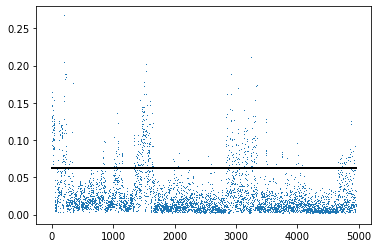

In [ ]:
errors = []
anom = []

i = 1
num_anom = 0

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(testing, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	# and the number of detected anomalies is stored in num_anom variable
	mse = np.mean((image - recon) ** 2)
	errors.append(mse) 

for e in errors:
  if e > thrashold:
    num_anom += 1
    anom.append(i)
  i += 1
plt.plot(errors,',')
plt.plot([0, testing.shape[0]], [thrashold, thrashold], 'k-', lw=2)
print(num_anom)
print(anom[0])

#Some visualization

For whole image classification

In [29]:
pth_F = 'DL_Project/FV-Cells/Policristal/Txarrak'

fl_F = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_F)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)and ('heat' not in name)]
len(fl_F)
st=0
anomalies = []
for i in range(len(fl_F)):

    fname = fl_F[st+i]
    print(fname)
    img = cv2.imread(fname,0)

    img_w = 512
    img_h = 512

    errors, images, img_origin, mask, subw = Predictions(fname, ' ',autoencoder,img_w,img_h,mask=True)

    errors = np.asarray(errors)
    print(errors.shape)
    plt.subplot(121)
    plt.plot(errors,'.')
    plt.subplot(122)
    plt.hist(errors,30)
    plt.show()
        
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(img*mask)
    plt.show()


For autoencoder with image segmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf

#============================================================================================================
##Predict IMAGE & Save classified bmp
def Predictions(fname, tgt_folder,model, new_w,new_h,overlap=0.6,mask=False):
    #imgs_, _ = img_procc(fname,type='All')
    #imgs_ = np.asarray(imgs_)
    #imgs_ = np.expand_dims(imgs_, axis=-1)
    #imgs_ = imgs_.astype("float32") / 255.0
    
    img_origin, images = SlidingWindow(fname, new_w,new_h,overlap)
    #images = tf.dtypes.cast(images, tf.float32)
    images = np.asarray(images)
    img_origin = np.asarray(img_origin)
    print(images.shape, images.dtype)
    images = np.expand_dims(images, axis=-1)
    images = images.astype("float32") / 255.0
    
        
    if False:
        plt.subplot(121)
        plt.imshow(images[100,:,:,0])
        plt.subplot(122)
        plt.hist(images[100,:,:,0])
        plt.show()
        #images = images / 255.0
    
    
    Predictions = []
    Masks = []
    Subws = []
        
    if True: #for i in range(len(Models)):
        #decoded = model.predict(images)
        decoded = model(images)
        
        # loop over all original images and their corresponding
        # reconstructions
        #decoded = autoencoder.predict(CrackX)
        errors = []
        for (image, recon) in zip(images, decoded):
            # compute the mean squared error between the ground-truth image
            # and the reconstructed image, then add it to our list of errors
            mse = np.mean((image - recon) ** 2)
            errors.append(mse)
        
               
        if mask:
            img_mask = np.zeros(img.shape)
            img_subw = np.zeros(img.shape)
            for i in range(img_origin.shape[0]):
                w_rng = [img_origin[i,0],img_origin[i,0]+new_w]
                h_rng = [img_origin[i,1],img_origin[i,1]+new_h]
                # Next mask will tell how many times each pixes has been included for classification in a subwindow
                img_subw[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]] = img_subw[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]+1
                if errors[i]>0.014: #06:
                    #print('anomaly')
                    v = (errors[i]-0.001)/(0.006-0.004)
                    if v>1:
                        v=1
                    elif v<0:
                        v=0
                    img_mask[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]] = 1

            #img_mask = img_mask*img_subw.max()/img_subw
            #img_mask = img_mask/img_subw
            #img_mask[img_mask<0.65]=0
        else:
            img_mask = []
            img_subw = []
            
        Predictions = errors
        Masks = img_mask
        Subws = img_subw
            

    
    return Predictions, images, img_origin, Masks, Subws


def SlidingWindow(fname, new_w,new_h,overlap=0.5):
    img = cv2.imread(fname,0)
    #img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)#For monocristal cells to mantain proportions
    #img = cv2.GaussianBlur(img,(5,5),0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    
    
    img_w = img.shape[0]
    img_h = img.shape[1]
    
    images = []
    img_origin = []
    w_len = 0
    for i,vali in enumerate(range(0,img_w,int(new_w - overlap*new_w))):
        h_len = 0
        if w_len != 1: #NO estamos en la esquina de la figura
            for j,valj in enumerate(range(0,img_h,int(new_h - overlap*new_h))):
                if h_len != 1: # NO estamos en la esquina de la figura
                    #take img
                    w_rng = [vali, vali+new_w]
                    h_rng = [valj, valj+new_h]
                    if (vali+new_w > img_w):
                        w_len=1 #estamos en la esquina de la figura
                        w_rng = [img_w-new_w, img_w]
                    if (valj+new_h > img_h):
                        h_len=1    
                        h_rng = [img_h-new_h, img_h]
                    
                    new_img = img[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]
                    #new_img = img_to_array(new_img)
                    #print(new_img.shape)
                    
                    #print(new_img)
                    images.append(new_img)                    
                    img_origin.append([w_rng[0], h_rng[0]])
                        
    #images = np.asarray(images)
    #img_origin = np.asarray(img_origin)
    return img_origin, images

In [ ]:
pth_F = 'DL_Project/FV-Cells/Policristal/Txarrak'

fl_F = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_F)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)and ('heat' not in name)]
len(fl_F)
st=0
anomalies = []
for i in range(len(fl_F)):

    fname = fl_F[st+i]
    print(fname)
    img = cv2.imread(fname,0)

    img_w = 64
    img_h = 64

    errors, images, img_origin, mask, subw = Predictions(fname, ' ',autoencoder,img_w,img_h,mask=True)

    errors = np.asarray(errors)
    print(errors.shape)
    plt.subplot(121)
    plt.plot(errors,'.')
    plt.subplot(122)
    plt.hist(errors,30)
    plt.show()
        
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(img*mask)
    plt.show()
    
    if True: #Save Anomaly for Anomaly Dataset
        idxs = np.where(errors>0.006)[0]
        if not(len(idxs)==0):
            for i in idxs:
                anomalies.append(images[i])

Output hidden; open in https://colab.research.google.com to view.

#3. U-net model creation

Input data preparation

In [ ]:
input_img = []
input_ROI = []

w, h = 256, 256
dim = (w, h)

for pth in filesC:
  img = cv2.imread(pth,0)/255.
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  input_img.append(img)

for pth in ROIs:
  img = cv2.imread(pth,0)/255.
  img = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)
  input_ROI.append(img)

input_img = np.array(input_img)
input_ROI = np.array(input_ROI)

In [ ]:
#Spliting dataset into train and test. To do so shuffle indexes and split 80/20:

# Shuffle the values:
#id_shuf = np.argsort(np.random.rand(input_img.shape[0])) # Get indexes of the sorted values
#input_img = input_img[id_shuf]
#input_ROI = input_ROI[id_shuf]

# Now split the dataset:
split = 0.8*input_img.shape[0]
train_img, test_img, train_ROI, test_ROI = [], [], [], []
i, j = 1, 1
for img in input_img:
  if  i <= split:
    train_img.append(img)
  else:
    test_img.append(img)
  i+=1
for ROI in input_ROI:
  if  j <= split:
    train_ROI.append(ROI)
  else:
    test_ROI.append(ROI)
  j+=1

train_img = np.array(train_img)
train_ROI = np.array(train_ROI)
test_img = np.array(test_img)
test_ROI = np.array(test_ROI)

print(train_img.shape)

(116, 256, 256)


Some visualization

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(train_img[1])
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(train_ROI[1])
plt.show()

In [ ]:
#Our U-Net network wants to qualify each pixel of input as background or defect
# and then combine the results in one image - ROI, to achive this we need to 
# provide input in shape of [x, x, 2], so we firstly add new axises:
train_img = train_img[:, :, :, np.newaxis]
test_img = test_img[:, :, :, np.newaxis]
#and then copy the inputs to the new axis:
train_img = np.append(train_img, train_img, axis = 3)
test_img = np.append(test_img, test_img, axis = 3)
print(train_img.shape)

(116, 256, 256, 2)


Declaration of parts

In [19]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 2, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 2, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [20]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [21]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 2, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [22]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # second layer
    x = layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

And finally building the models

In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(256,256,2))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [17]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = layers.Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [23]:
#unet_model = build_unet_model()
input = tf.keras.Input(shape = (256,256,2,))
unet2 = get_unet(input)

In [ ]:
unet2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 256, 256, 16  304         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 256, 256, 16  64         ['conv2d_22[0][0]']              
 ormalization)                  )                                                           

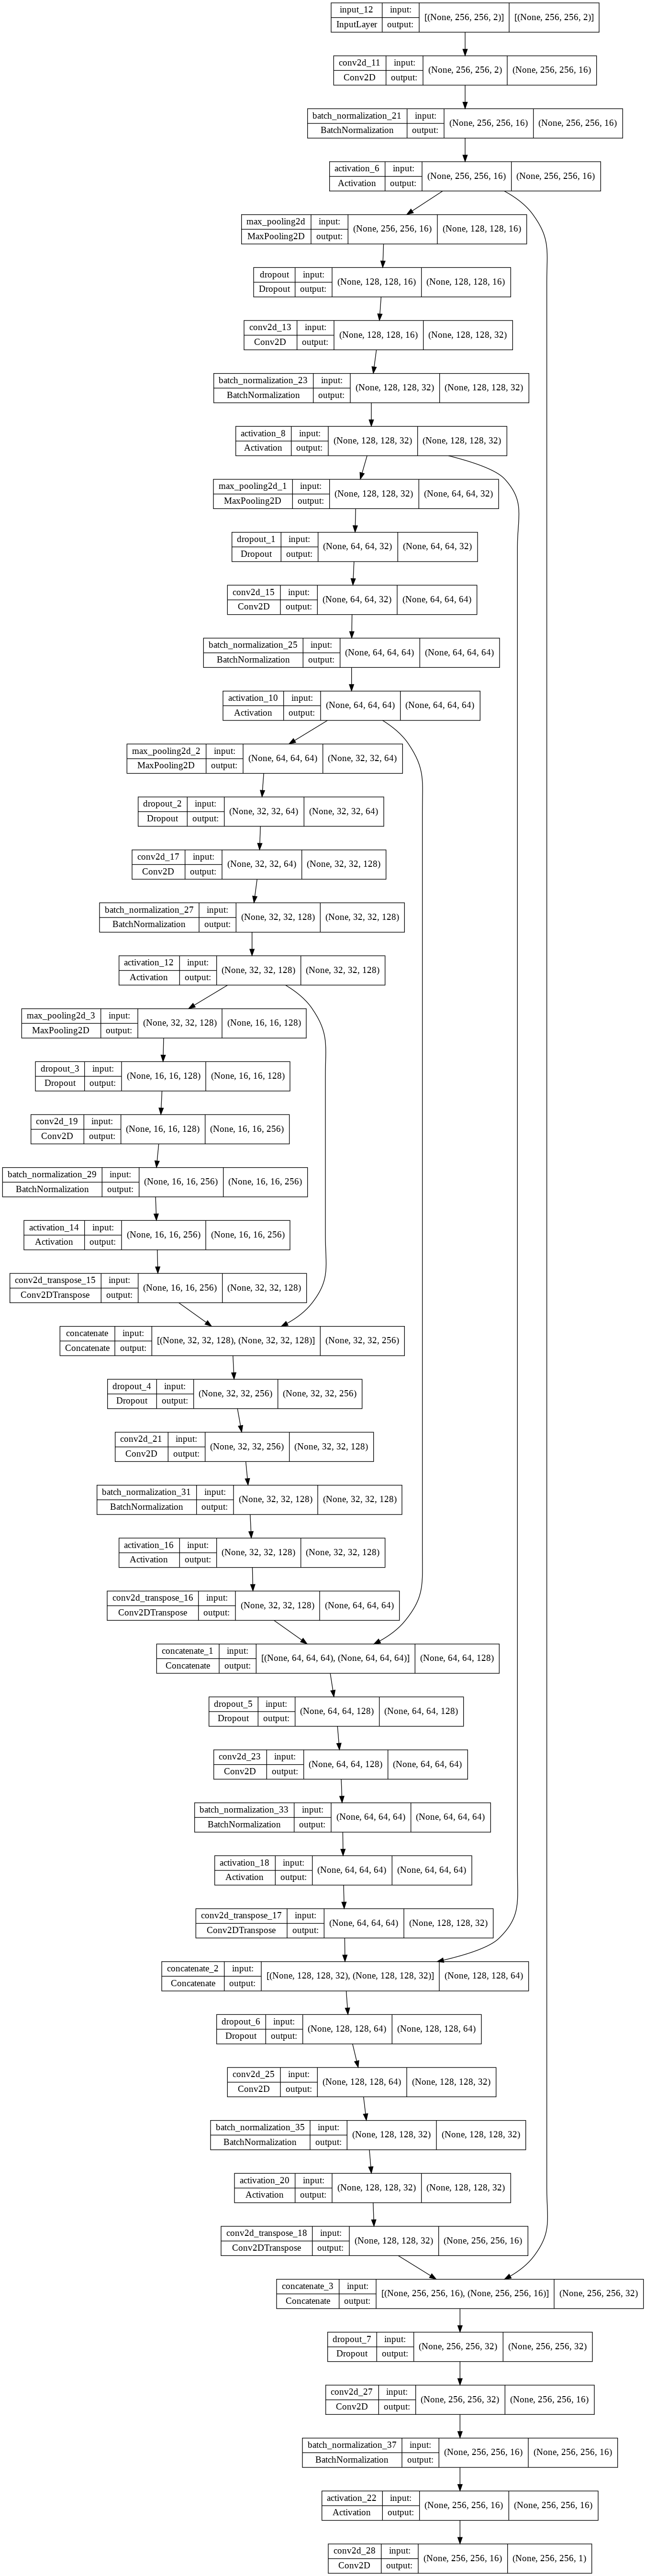

In [24]:
tf.keras.utils.plot_model(unet2, show_shapes=True)

In [ ]:
#unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   #loss="binary_crossentropy",
                   #metrics="accuracy")
unet2.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="binary_crossentropy",
                   metrics="accuracy")

In [ ]:
NUM_EPOCHS = 15

model_history = unet2.fit(train_img, train_ROI, 
                 validation_data=(test_img, test_ROI), epochs=NUM_EPOCHS, batch_size = 8)

Epoch 1/15
15/15 [==============================] - 55s 3s/step - loss: 0.6119 - accuracy: 0.7358 - val_loss: 9.7541 - val_accuracy: 0.1424
Epoch 2/15
15/15 [==============================] - 52s 3s/step - loss: 0.4200 - accuracy: 0.9681 - val_loss: 0.8309 - val_accuracy: 0.4932
Epoch 3/15
15/15 [==============================] - 50s 3s/step - loss: 0.3341 - accuracy: 0.9869 - val_loss: 0.4086 - val_accuracy: 0.9335
Epoch 4/15
15/15 [==============================] - 50s 3s/step - loss: 0.2799 - accuracy: 0.9918 - val_loss: 0.3157 - val_accuracy: 0.9909
Epoch 5/15
15/15 [==============================] - 50s 3s/step - loss: 0.2402 - accuracy: 0.9931 - val_loss: 0.1540 - val_accuracy: 0.9931
Epoch 6/15
15/15 [==============================] - 50s 3s/step - loss: 0.2165 - accuracy: 0.9935 - val_loss: 0.1574 - val_accuracy: 0.9931
Epoch 7/15
15/15 [==============================] - 50s 3s/step - loss: 0.1925 - accuracy: 0.9938 - val_loss: 0.1715 - val_accuracy: 0.9931
Epoch 8/15
15/15 [==

Visualize the results

In [ ]:
#Load the data of defected cells
fpath = 'DL_Project/FV-Cells/Policristal/Txarrak'

bmpfiles = [os.path.join(root, name)
            for root, dirs, files in os.walk(fpath)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)and ('heat' not in name)]


print(len(bmpfiles))

145


0 DL_Project/FV-Cells/Policristal/Txarrak/1002.bmp
Have a ROI


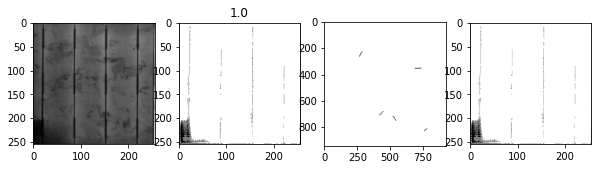

1 DL_Project/FV-Cells/Policristal/Txarrak/1009.bmp
Have a ROI


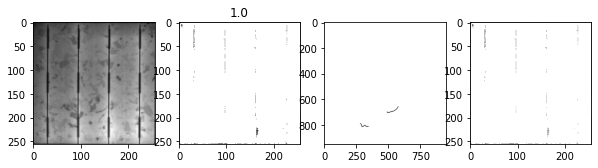

2 DL_Project/FV-Cells/Policristal/Txarrak/1011.bmp
Have a ROI


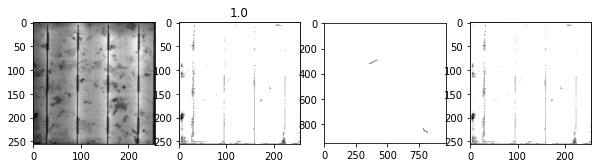

3 DL_Project/FV-Cells/Policristal/Txarrak/1008.bmp
Have a ROI


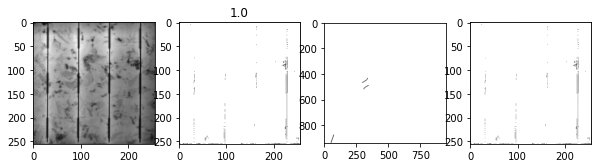

4 DL_Project/FV-Cells/Policristal/Txarrak/1010.bmp
Have a ROI


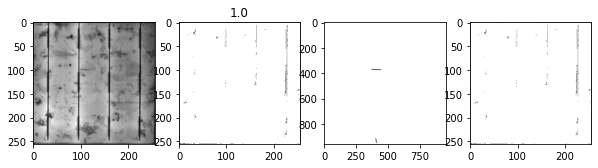

In [ ]:
st = 3
for val,fname in enumerate(bmpfiles[st:st+5]):
    print(val,fname)
    ny = 256 
    nx = 256 
    
    images = np.zeros((1, nx, ny, 2))
    
    img = cv2.imread(fname,0)/255.
    img = cv2.resize(img, (ny,nx), interpolation = cv2.INTER_AREA)
    
    images[0,:,:,0]=img

    img_heat_ = unet2(np.float32(images))

    img_heat = img_heat_[0,:,:,0]
    
    im4=np.asarray(img_heat).copy()
    cte=0.9
    im4[im4>cte]=1.
    im4[im4<cte]=0.
    
    nm1 = fname.replace('.bmp','_ROI.bmp')
    img1 = []
    try:
        img1 = cv2.imread(nm1,0)
        if img1==None:
            img1=np.zeros(img.shape)    
    except:
        print('Have a ROI')
       
    
    im5 = 0.8*np.float32(img) + im4
    im5[im5>1]=1
    
    if True:
        plt.figure(figsize=(10,10))
        plt.subplot(141)    
        plt.imshow(img,cmap='gray')

        plt.subplot(142)
        plt.title(im4.max())
        plt.imshow(im4,cmap='gray')

        plt.subplot(143)
        plt.imshow(img1,cmap='gray')
        
        plt.subplot(144)
        nm1 = fname.replace('.jpg','_ROI_Mono2.bmp')
        #print(nm1, str(img_heat.max()))

        #dest = cv2.addWeighted(im5, 0.8, im4, 0.5, 0.0)
        plt.imshow(im5,cmap='gray')

        plt.show()

In [ ]:
print(fname)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

(1, 256, 256, 2)
(1, 256, 256, 1)
0.90624475
(256, 256, 1)
(256, 256)


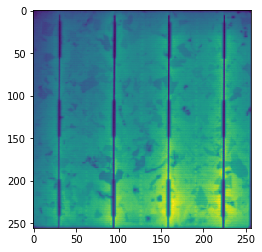

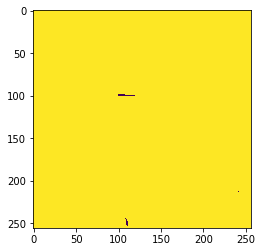

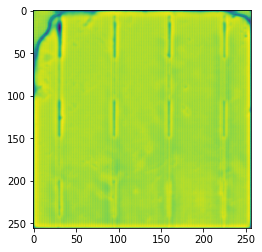

In [ ]:
#Visualize some results:
test = train_img[4]
test = test[None, :]
print(test.shape)
prediction = unet2.predict(test)
print(prediction.shape)
mask = (prediction [:, :, :, 0])
result = mask[0]
print(result[15, 15])


#display([test_img[5], test_ROI[5], create_mask(prediction)])
image = train_img[4]
image = image[:, :, : 1]
print(image.shape)
imager = image[:,:,0]
ROI = train_ROI[4]
print(ROI.shape)
plt.imshow(imager, interpolation='nearest')
plt.show()
plt.imshow(ROI, interpolation='nearest')
plt.show()
plt.imshow(result)
plt.show()




#3.2 Unet 100

In [ ]:
#Use the pretrained unet model for monocristal images
unet_100 = tf.saved_model.load('MonoCristal_UNET_100')

load testing data

In [ ]:
fpath = 'DL_Project/FV-Cells/Policristal/Txarrak'

bmpfiles = [os.path.join(root, name)
            for root, dirs, files in os.walk(fpath)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)and ('heat' not in name)]


print(len(bmpfiles))

145


0 DL_Project/FV-Cells/Policristal/Txarrak/1002.bmp
Dont have a ROI


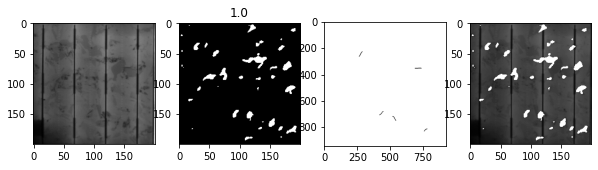

1 DL_Project/FV-Cells/Policristal/Txarrak/1009.bmp
Dont have a ROI


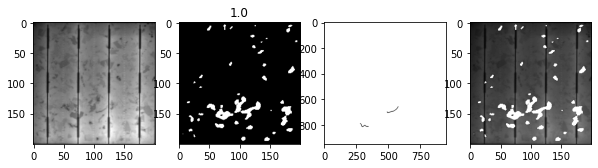

2 DL_Project/FV-Cells/Policristal/Txarrak/1011.bmp
Dont have a ROI


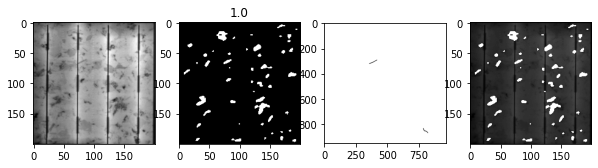

3 DL_Project/FV-Cells/Policristal/Txarrak/1008.bmp
Dont have a ROI


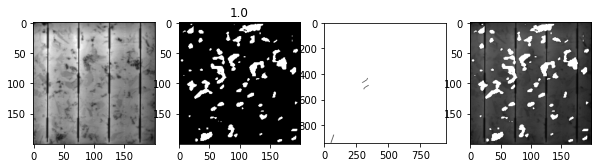

4 DL_Project/FV-Cells/Policristal/Txarrak/1010.bmp
Dont have a ROI


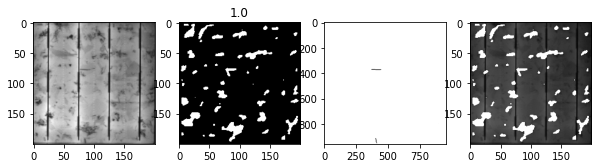

In [ ]:
st = 3
for val,fname in enumerate(bmpfiles[st:st+5]):
    print(val,fname)
    
    
    
    ny = 200 
    nx = 200 
    
    images = np.zeros((2, nx, ny, 1))
    
    img = cv2.imread(fname,0)/255.
    img = cv2.resize(img, (ny,nx), interpolation = cv2.INTER_AREA)
    
    images[0,:,:,0]=img
    
    img_heat_ = unet_100(np.float32(images))
    img_heat = img_heat_[0,:,:,1]
    
    im4=np.asarray(img_heat).copy()
    cte=0.1
    im4[im4>cte]=1.
    im4[im4<cte]=0.
    
    nm1 = fname.replace('.bmp','_ROI.bmp')
    #print(nm1, str(img_heat.max()))
    img1 = []
    try:
        img1 = cv2.imread(nm1,0)
        if img1==None:
            img1=np.zeros(img.shape) 
    except:
        print('Dont have a ROI')
       
    
    im5 = 0.8*np.float32(img) + im4
    im5[im5>1]=1
    
    if True:
        plt.figure(figsize=(10,10))
        plt.subplot(141)    
        plt.imshow(img,cmap='gray')

        plt.subplot(142)
        plt.title(im4.max())
        plt.imshow(im4,cmap='gray')

        plt.subplot(143)
        plt.imshow(img1,cmap='gray')
        
        plt.subplot(144)
        plt.imshow(im5,cmap='gray')

        plt.show()